In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
from tensorflow import keras
from utils.helper import (
    folder_to_sequence,
    MinMaxScaler_AE,
)
import sys
import locale 

locale.setlocale(locale.LC_ALL, "pt_BR.UTF-8")
sys.path.append("../")

plt.style.use(["science", "ieee", "notebook"])

plt.rcParams["font.size"] = 10
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (9, 4)
plt.rcParams['axes.formatter.use_locale'] = True

c:\Users\vinim\OneDrive\Documentos\Projetos\TCC\fluidization-AE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DEFAULT_WS = 20

In [27]:
import optuna

study = optuna.load_study(
    study_name="LSTM-v2",
    storage="sqlite:///../models/optuna_study.db"
)
model_path = study.best_trial.user_attrs["model_path"]
study.trials_dataframe().sort_values(
    "value", ascending=True
).head()

,number,value,datetime_start,datetime_complete,duration,params_dropout_rate,params_l1,params_l2,params_n_units,user_attrs_model_path,state
15,15,0.001128,2025-04-23 17:09:36.748456,2025-04-23 20:18:43.520949,0 days 03:09:06.772493,0.15,0.000002,0.000005,96,../models/model_15.keras,COMPLETE
12,12,0.001213,2025-04-23 17:09:36.664151,2025-04-23 18:22:23.483874,0 days 01:12:46.819723,0.10,0.000007,0.000007,64,../models/model_12.keras,COMPLETE
13,13,0.001313,2025-04-23 17:09:36.704273,2025-04-23 20:58:30.204366,0 days 03:48:53.500093,0.30,0.000001,0.000021,128,../models/model_13.keras,COMPLETE
17,17,0.002452,2025-04-23 17:09:36.814817,2025-04-23 21:36:39.544241,0 days 04:27:02.729424,0.40,0.000122,0.000007,96,../models/model_17.keras,COMPLETE
14,14,0.003305,2025-04-23 17:09:36.671388,2025-04-23 21:47:53.281921,0 days 04:38:16.610533,0.30,0.000327,0.000015,128,../models/model_14.keras,PRUNED


In [28]:
Xnormal, Ynormal = folder_to_sequence("VIDRO-B3", DEFAULT_WS)
Xpainco, Ypainco = folder_to_sequence("PAINCO", DEFAULT_WS)
Xmenos, Ymenos = folder_to_sequence("ANOMALIAS/B3-200g", DEFAULT_WS)

Xscaler = MinMaxScaler_AE()
Yscaler = MinMaxScaler_AE()

Xscaler.fit(Xnormal)
Yscaler.fit(Ynormal)

Xnormal = Xscaler.transform(Xnormal)
Xpainco = Xscaler.transform(Xpainco)
Xmenos = Xscaler.transform(Xmenos)

Ynormal = Yscaler.transform(Ynormal)
Ypainco = Yscaler.transform(Ypainco)
Ymenos = Yscaler.transform(Ymenos)

seq2seq = keras.models.load_model(model_path)

100%|██████████| 23/23 [00:00<00:00, 42.24it/s]


In [38]:
# print(seq2seq.history)

# seq2seq.summary()
seq2seq.count_params()

111841

In [39]:
from joblib import Parallel, delayed


# Function to perform a single stochastic forward pass with dropout
def stochastic_forward_pass(model, X_test):
    return model(X_test, training=True).numpy()


# Function to perform MC Dropout with parallel computation
def mc_dropout_predict_parallel(model, X_test, n_forward_passes=100, n_jobs=-1):
    # Use joblib to run parallel forward passes
    predictions = Parallel(n_jobs=n_jobs)(
        delayed(stochastic_forward_pass)(model, X_test) for _ in range(n_forward_passes)
    )

    # Convert predictions list into numpy array
    predictions = np.array(
        predictions
    )  # Shape: (n_forward_passes, n_samples, time_steps)

    # Compute mean and uncertainty (standard deviation)
    mean_prediction = np.mean(predictions, axis=0)  # Mean across forward passes
    assert mean_prediction.shape[1] == X_test.shape[1], f"Shape mismatch: {mean_prediction.shape} != {X_test.shape}"

    uncertainty = np.std(predictions, axis=0)  # Uncertainty (std dev)

    return mean_prediction, uncertainty

In [14]:
Xmenos.shape

(8665, 20, 1)

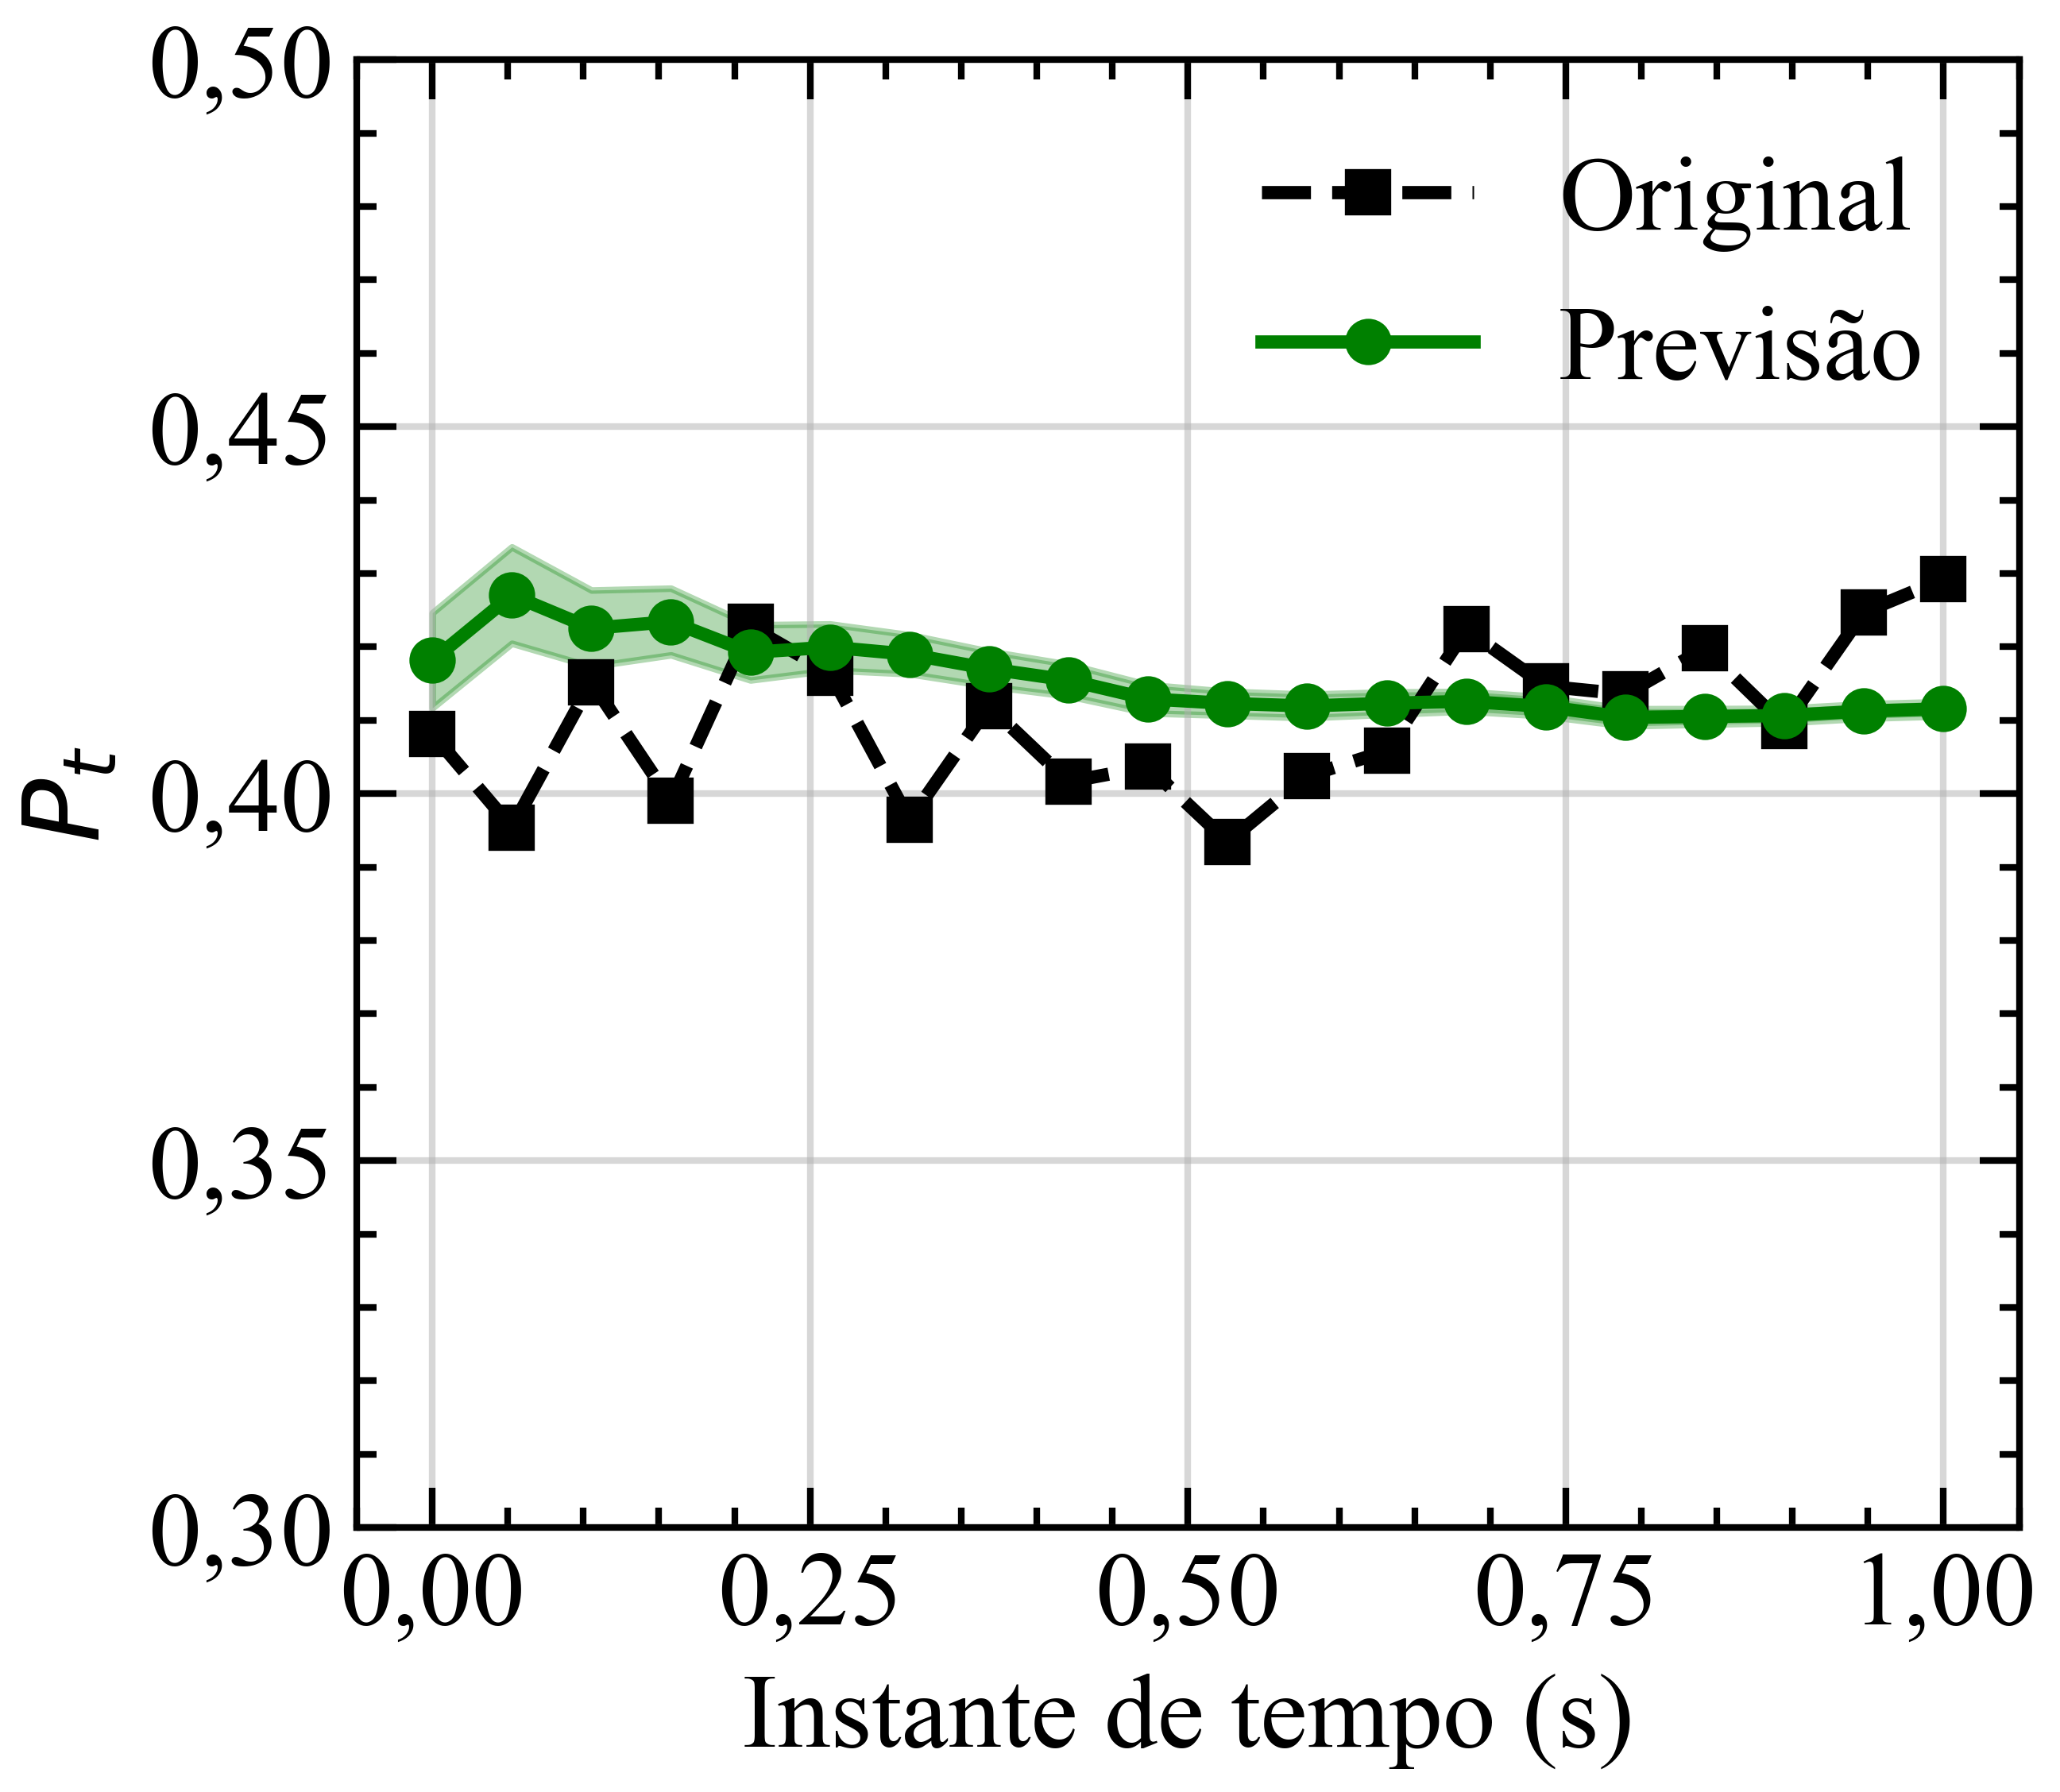

In [40]:
index: int = 6000
mean, std = mc_dropout_predict_parallel(
    seq2seq, np.expand_dims(Xnormal[index], 0), 10
)

plt.figure(figsize=(4.5, 4))
plt.grid(alpha=0.5)
# plt.xticks(np.ar5nge(0, 22, 2) * 1 / 20)
ymin = (mean - std).flatten()
ymax = (mean + std).flatten()

x = np.linspace(0, 20, len(Xnormal[index])) * 1 / 20

plt.plot(x, Ynormal[index], label="Original", marker='s', ls='--')

plt.plot(x, mean.flatten(), label="Previsão", c="green", marker='o', ls='-')
plt.xlabel("Instante de tempo (s)")
plt.ylabel(r"$P_t$")
plt.fill_between(x, ymin, ymax, alpha=0.3, color="green")
plt.legend()
plt.ylim(bottom=0.3, top=0.50)

plt.savefig("../images/seq2seq/normal_prediction.png", dpi=300, bbox_inches="tight");

In [41]:
print(index)
Xmenos[50].mean(), Xnormal[6000].mean()

6000


(0.059889114208051056, 0.0606182853691159)

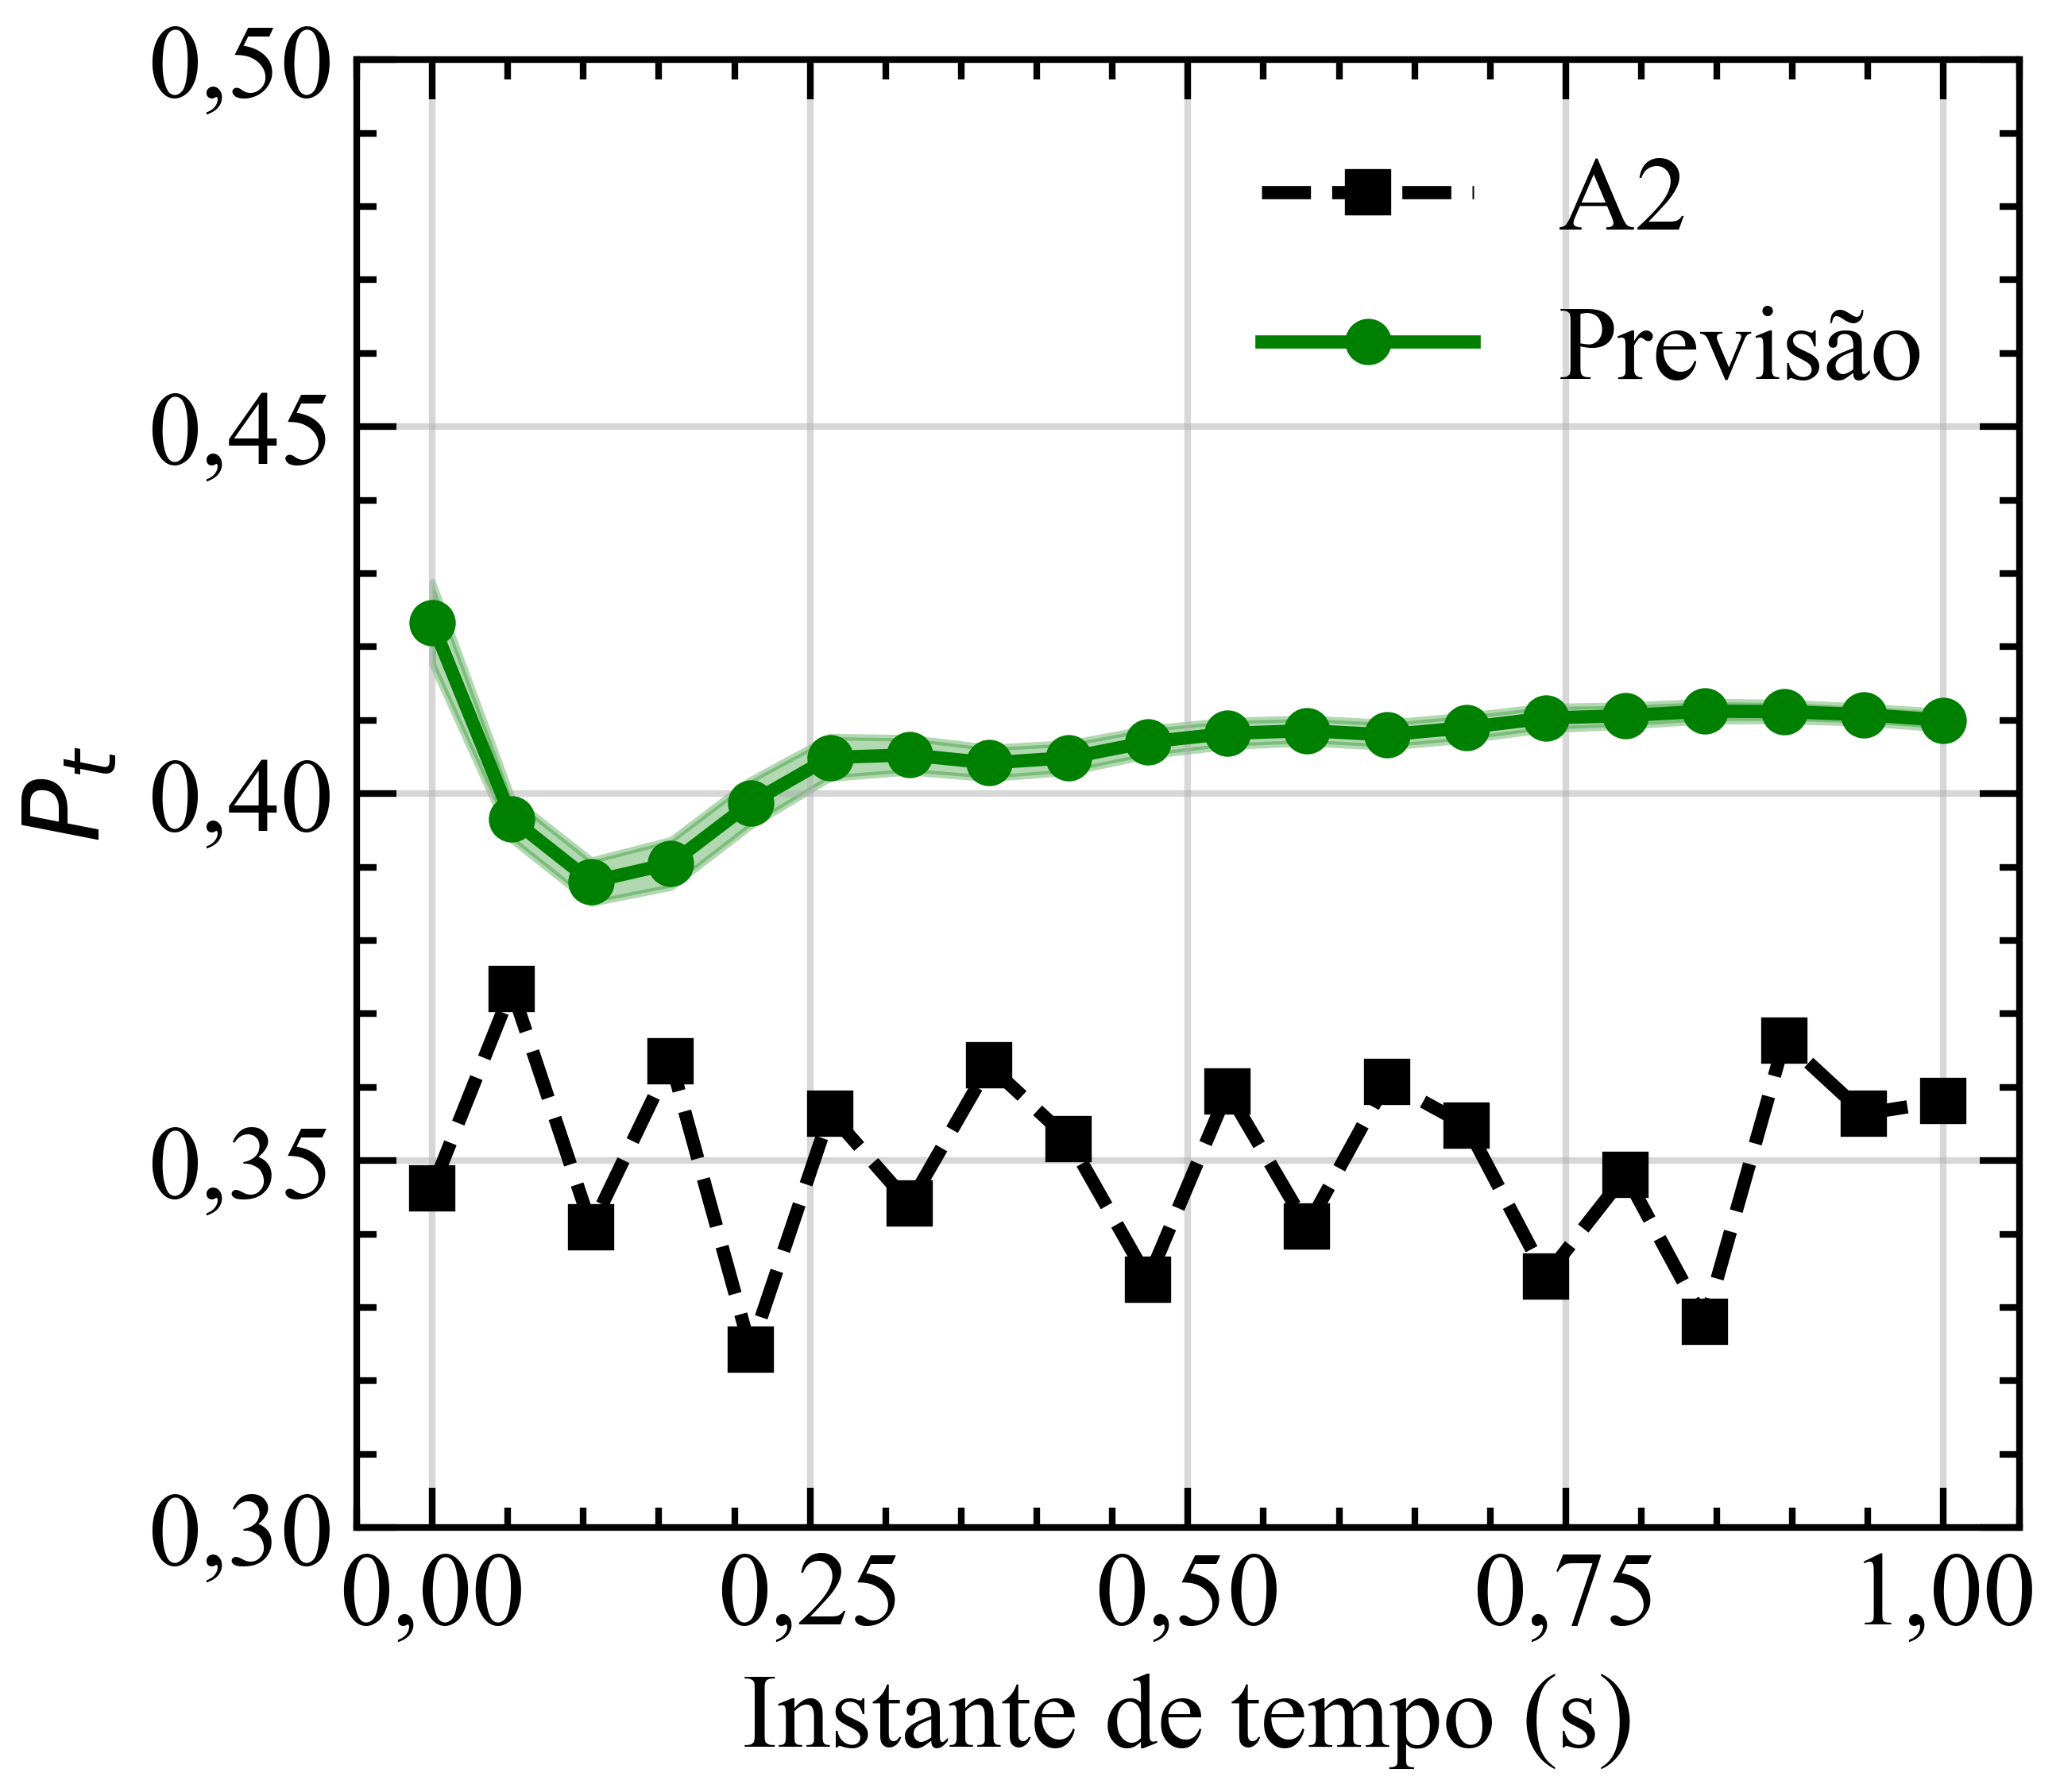

In [42]:
index: int = 50
mean, std = mc_dropout_predict_parallel(
    seq2seq, np.expand_dims(Xmenos[index], 0), 10
)

plt.figure(figsize=(4.5, 4))
plt.grid(alpha=0.5)
# plt.xticks(np.arange(0, 22, 2) * 1 / 20)
ymin = (mean - std).flatten()
ymax = (mean + std).flatten()

x = np.linspace(0, 20, len(Xmenos[index])) * 1 / 20

plt.plot(x, Ymenos[index], label="A2", marker='s', ls='--')
plt.plot(x, mean.flatten(), label="Previsão", c="green", marker='o', ls='-')

y_actual = Ymenos[index].flatten()
y_pred = mean.flatten()

# for i in range(len(x)):
#     plt.plot([x[i], x[i]], [y_actual[i], y_pred[i]], c="red", ls=":", alpha=0.3)

plt.xlabel("Instante de tempo (s)")
plt.ylabel(r"$P_t$")
plt.fill_between(x, ymin, ymax, alpha=0.3, color="green")
plt.legend()
plt.ylim(bottom=0.3, top=0.5)

plt.savefig("../images/seq2seq/b3-200g_prediction.png", dpi=300, bbox_inches="tight");